<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [195]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import pandas as pd
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [196]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-03-16 06:09:09--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-03-16 06:09:09 (10.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [197]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [198]:
df.shape

(346, 10)

### Convert to date time object 

In [199]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [200]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to understand data better:

In [201]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
seaborn                   0.9.0                    py35_0    anaconda


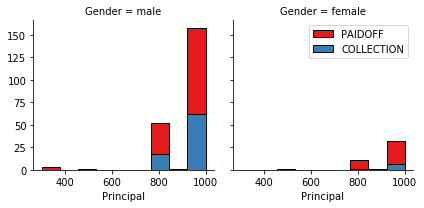

In [202]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

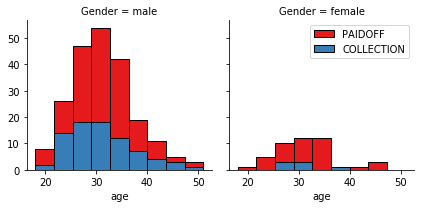

In [203]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

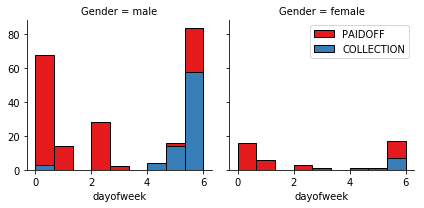

In [204]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [205]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [206]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [207]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [208]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [209]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [210]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [211]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [212]:
y = df['loan_status'].values
y_labels=set(y)
print (y[0:5])
print (y_labels)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
{'PAIDOFF', 'COLLECTION'}


## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [213]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [214]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)

Train set: (276, 8) (276,)


In [215]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_KNN = neigh.predict(X_test)
print(yhat_KNN[0:5])
from sklearn import metrics
print("Train set Accuracy: ", np.mean(neigh.predict(X_train) == y_train))
print("Test set Accuracy: ", np.mean(yhat_KNN == y_test))

['PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Train set Accuracy:  0.815217391304
Test set Accuracy:  0.685714285714


### Find the best K for KNN

In [216]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = np.mean(yhat==y_test)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print( "Mean accuracies were:", mean_acc )

Mean accuracies were: [ 0.67142857  0.65714286  0.71428571  0.68571429  0.75714286  0.71428571
  0.78571429  0.75714286  0.75714286  0.67142857  0.7         0.72857143
  0.7         0.7         0.68571429  0.72857143  0.72857143  0.72857143
  0.7       ]


### Plot the accuracy of different values of K for KNN

In [217]:
# First, define a plotting function that we can re-use for the other classifiers
def plotComparison(label, min, max, mean_acc, std_acc):
    plt.plot(range(min, max), mean_acc, 'g')
    plt.fill_between(range(1, max), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
    plt.legend(('Accuracy ', '+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('K')
    plt.tight_layout()
    plt.show()

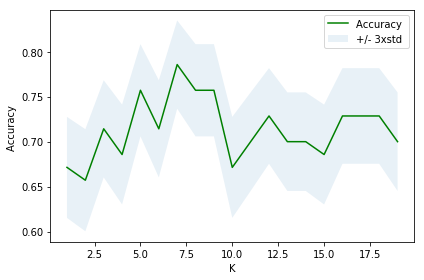

In [218]:
# and now plot!
plotComparison("K Nearest Neighbour", 1, Ks, mean_acc, std_acc)

#### What was the Best K for K Nearest Neighbour?

In [219]:
bestK = mean_acc.argmax() + 1
bestKAccuracy = mean_acc.max()
print("The best accuracy was with K =", bestK, " (mean accuracy:", bestKAccuracy, ")")

The best accuracy was with K = 7  (mean accuracy: 0.785714285714 )


In [220]:
# Build ourselves our Best KNN Classifier
bestKNN = KNeighborsClassifier(n_neighbors = bestK).fit(X_train, y_train)

# Decision Tree

In [221]:
from sklearn.tree import DecisionTreeClassifier

In [222]:
# Inside of the classifier, specify criterion="entropy" so we can see the information gain of each node.
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
print(loanTree)
loanTree.fit(X_train,y_train)
yhat_tree = loanTree.predict(X_test)
#print (yhat_tree [0:5])
#print (y_testset [0:5])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### Find the best K for Decision Tree

In [223]:
# Check the accuracy
from sklearn import metrics
import matplotlib.pyplot as plt
print("Original DecisionTrees's Accuracy: ", np.mean(yhat_tree==y_test))
max_k=20
tree_mean_acc = np.zeros((max_k-1))
tree_std_acc = np.zeros((max_k-1))

# compare different depths
for k in range(1, max_k):
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = k)
    loanTree.fit(X_train,y_train)
    yhat = loanTree.predict(X_test)
    tree_mean_acc[k-1] = np.mean(yhat==y_test)
    tree_std_acc[k-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print( "Mean accuracies were:", tree_mean_acc )
print( "Std accuracies were:", tree_std_acc )

Original DecisionTrees's Accuracy:  0.614285714286
Mean accuracies were: [ 0.78571429  0.78571429  0.61428571  0.61428571  0.64285714  0.77142857
  0.75714286  0.75714286  0.65714286  0.7         0.7         0.71428571
  0.7         0.71428571  0.72857143  0.7         0.68571429  0.7         0.7       ]
Std accuracies were: [ 0.04904333  0.04904333  0.05817937  0.05817937  0.05727027  0.05018915
  0.05125253  0.05125253  0.05673323  0.05477226  0.05477226  0.05399492
  0.05477226  0.05399492  0.05315141  0.05477226  0.05548619  0.05477226
  0.05477226]


### Plot the accuracy of different values of K for Decision Tree

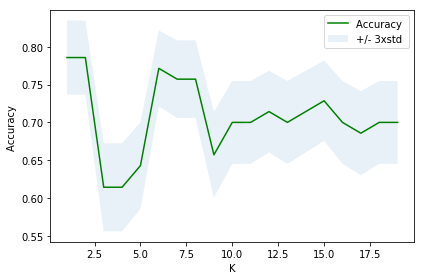

In [224]:
plotComparison("k", 1, max_k, tree_mean_acc, tree_std_acc)

#### What was the Best K for Decision Tree?

In [225]:
bestTreeAccuracy = tree_mean_acc.max()
bestTreeK = tree_mean_acc.argmax() + 1
print("The best accuracy was with K =", bestTreeK, " (mean accuracy:", bestTreeAccuracy, ")")
# Depth of 6 looks like it will do better in a larger data set.
# Build ourselves our Best Decision Tree Classifier
bestDTree = DecisionTreeClassifier(criterion="entropy", max_depth = bestTreeK)
bestDTree.fit(X_train, y_train)

The best accuracy was with K = 1  (mean accuracy: 0.785714285714 )


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Draw the tree

In [226]:
## Notice: You the conda install takes a while, so this section commented out and not required for the rest of the cells to work.
## Only uncomment the code in this cell if you are curious about how the tree looks
## (to uncomment: select all lines below this in the cell then press Ctrl and '/')
## Uncomment below here if curious:

# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

# from sklearn.externals.six import StringIO
# import pydotplus
# import matplotlib.image as mpimg
# from sklearn import tree
# %matplotlib inline

# def plotTree(filename, treeToDisplay):
#     dot_data = StringIO()
#     featureNames = Feature.columns
#     targetNames = np.unique(y)
#     out=tree.export_graphviz(treeToDisplay, feature_names=featureNames, out_file=dot_data, class_names=np.unique(y_trainset), filled=True, special_characters=True, rotate=False)  
#     graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#     graph.write_png(filename)
#     img = mpimg.imread(filename)
#     plt.figure(figsize=(80, 160))
#     plt.imshow(img,interpolation='nearest')

# # The Best decision tree accuracy was with depth 1 and 2, but with a 2nd peak at depth 6. 
# # Uncomment below to see what depth 6 would look like
# # loanTreeToDisplay = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
# # loanTreeToDisplay.fit(X_trainset,y_trainset)
# # plotTree("loantree.png", loanTreeToDisplay)

# plotTree("loantree.png", bestDTree)


# Support Vector Machine (SVM)

In [227]:
from sklearn import svm
svc = svm.SVC(kernel='rbf')
svc.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [228]:
# make predictions
yhat = svc.predict(X_test)
yhat [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Evaluate SVM

In [229]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat))
yhat_SVM = yhat

Avg F1-score: 0.7276
Jaccard score: 0.7429


### Find the best K for SVM (evaluate different kernels)

Comparing kernels: ['linear', 'poly', 'rbf', 'sigmoid']
Mean accuracies were: [ 0.78571429  0.77142857  0.74285714  0.74285714]


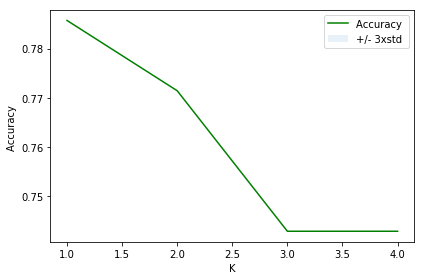

In [230]:
# compare different Kernels

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
numCs=len(Cs)
numKs=len(kernels)
svc_mean_acc = np.zeros(numKs)
svc_std_acc = np.zeros(numKs)

print("Comparing kernels:", kernels)
for k in range(0, numKs):
    svc = svm.SVC(kernel=kernels[k])
    svc.fit(X_train, y_train)
    yhat = svc.predict(X_test)
    currentIndex = k
    svc_mean_acc[currentIndex] = np.mean(yhat==y_test)
print( "Mean accuracies were:", svc_mean_acc )

plotComparison("kernel", 1, numKs+1, svc_mean_acc, svc_std_acc)

### What was the best K for SVM?

In [231]:
bestKernelAccuracy = svc_mean_acc.max()
bestKernelK = svc_mean_acc.argmax()
print("The best accuracy was", bestKernelAccuracy, "for Kernel:", kernels[bestKernelK])

bestSVM = svm.SVC(kernel=kernels[bestKernelK])
bestSVM.fit(X_train,y_train)

The best accuracy was 0.785714285714 for Kernel: linear


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

In [257]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01).fit(X_train,y_train)
yhat_LR = LR.predict(X_test)
yhat_LR_prob = LR.predict_proba(X_test)

In [258]:
k = "Logistic Regression"
from sklearn.metrics import log_loss
LogRegResults = (k, log_loss(y_test, yhat_LR_prob), f1_score(y_test, yhat_LR, average='weighted'), jaccard_similarity_score(y_test, yhat_LR))

print(k, "Mean score: %.4f" % np.mean(yhat_LR==y_test))
print(k, "Avg Logloss-score: %.4f" % log_loss(y_test, yhat_LR_prob))
print(k, "Avg F1-score: %.4f" % f1_score(y_test, yhat_LR, average='weighted'))
print(k, "Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat_LR))

Logistic Regression Mean score: 0.6857
Logistic Regression Avg Logloss-score: 0.5772
Logistic Regression Avg F1-score: 0.6671
Logistic Regression Jaccard score: 0.6857


### Find the best K: Compare solvers and C values

In [259]:
# For some added interest, let's compare how both solvers and C values affect the accuracy

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

numCs = len(Cs)
lr_bestKperSolver = []
bestOverallAccuracy = 0
for s in solvers:
    lr_mean_acc = np.zeros(numCs)
    for k in range(numCs):
        LR = LogisticRegression(C=Cs[k], solver=s).fit(X_train,y_train)
        yhat_LR = LR.predict(X_test)
        yhat_prob = LR.predict_proba(X_test)
        lr_mean_acc[k] = np.mean(yhat_LR==y_test)
    print( "Mean accuracies for solver", s, "were:", lr_mean_acc)
    
    # find the best K for this solver
    bestSolverAccuracy = lr_mean_acc.max()
    bestSolverK = lr_mean_acc.argmax()
    lr_bestKperSolver += ((s, bestSolverAccuracy, Cs[bestSolverK]))
    # keep track of the best overall combination
    if (bestSolverAccuracy > bestOverallAccuracy):
        bestOverallAccuracy = bestSolverAccuracy
        (bestSolver, bestAccuracy, bestK) = (s, bestSolverAccuracy, bestSolverK)
print ("\nThe best accuracy per Solver:", lr_bestKperSolver)

print ("\nThe best combination of solver and C was: ", bestSolver, Cs[bestK], "with accuracy", bestAccuracy)

Mean accuracies for solver newton-cg were: [ 0.78571429  0.78571429  0.78571429  0.78571429  0.77142857  0.72857143
  0.72857143]
Mean accuracies for solver lbfgs were: [ 0.78571429  0.78571429  0.78571429  0.78571429  0.77142857  0.72857143
  0.72857143]
Mean accuracies for solver liblinear were: [ 0.62857143  0.62857143  0.67142857  0.68571429  0.74285714  0.71428571
  0.71428571]
Mean accuracies for solver sag were: [ 0.78571429  0.78571429  0.78571429  0.78571429  0.77142857  0.72857143
  0.72857143]
Mean accuracies for solver saga were: [ 0.78571429  0.78571429  0.78571429  0.78571429  0.77142857  0.72857143
  0.71428571]

The best accuracy per Solver: ['newton-cg', 0.7857142857142857, 1e-05, 'lbfgs', 0.7857142857142857, 1e-05, 'liblinear', 0.74285714285714288, 0.1, 'sag', 0.7857142857142857, 1e-05, 'saga', 0.7857142857142857, 1e-05]

The best combination of solver and C was:  newton-cg 1e-05 with accuracy 0.785714285714


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [260]:
bestLR = LogisticRegression(C=Cs[bestK], solver=bestSolver).fit(X_train,y_train)

## Compare how the various models performed against the _Train/Test_ Set (compare against eval set later)

In [261]:
yhat_DTree = bestDTree.predict(X_test)
KNNScores = ('KNN', jaccard_similarity_score(y_test, yhat_KNN), f1_score(y_test, yhat_KNN, average='weighted'), 'NA')
DTreeScores = ('Decision Tree', jaccard_similarity_score(y_test, yhat_DTree), f1_score(y_test, yhat_DTree, average='weighted'), 'NA')
SVMScores = ('SVM', jaccard_similarity_score(y_test, yhat_SVM), f1_score(y_test, yhat_SVM, average='weighted'), 'NA')
LogRegScores = ('LogisticRegression', jaccard_similarity_score(y_test, yhat_LR), f1_score(y_test, yhat_LR, average='weighted'), log_loss(y_test, yhat_LR_prob))

data = [KNNScores, DTreeScores, SVMScores, LogRegScores]
df = pd.DataFrame(data, columns=('Algorithm', 'Jaccard', 'F1-score', 'LogLoss'), index=['','','',''])
df.round(2)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Algorithm,Jaccard,F1-score,LogLoss
,KNN,0.69,0.71,NA
,Decision Tree,0.79,0.69,NA
,SVM,0.74,0.73,NA
,LogisticRegression,0.71,0.69,0.577229


# Model Evaluation using Test set

In [262]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [263]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-03-16 06:17:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-03-16 06:17:19 (559 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [264]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Prepare Data for use

In [265]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

### Derive numeric fields and create Feature set

In [266]:
### Derive useful fields as numeric values
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male', 'female'], value=[0,1], inplace=True)

### One-hot encoding
Test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
Test_Feature = pd.concat([Test_Feature, pd.get_dummies(test_df['education'])], axis=1)
Test_Feature.drop(['Master or Above'], axis = 1, inplace=True)
Test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


### Define and normalize Evaluation set

In [267]:
y_eval = test_df['loan_status'].values
X_eval = preprocessing.StandardScaler().fit(Test_Feature).transform(Test_Feature)

### Evaluate Models using Evaluation data

In [268]:
# Now setup the classifiers using the whole of the original train/test dataset to fit the models
# then predict against the evaluatin data.

# KNN
#bestKNN.fit(X, y) # train on original test set
yhat_eval_KNN = bestKNN.predict(X_eval)

# SVM
#bestSVM.fit(X, y) # train on original test set
yhat_eval_SVM = bestSVM.predict(X_eval)

# DTree
#bestDTree.fit(X, y) # train on original test set
yhat_eval_DTree = bestDTree.predict(X_eval)

# LogReg
#LR_eval = bestLR.fit(X, y) # train on original test set
yhat_eval_LR = bestLR.predict(X_eval)
yhat_eval_LR_prob = bestLR.predict_proba(X_eval)

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

### Report: Summarize and display the comparison

In [269]:
# and evaluate table
EvalKNNScores = ('KNN', jaccard_similarity_score(y_eval, yhat_eval_KNN), f1_score(y_eval, yhat_eval_KNN, average='weighted'), 'NA')
EvalDTreeScores = ('Decision Tree', jaccard_similarity_score(y_eval, yhat_eval_DTree), f1_score(y_eval, yhat_eval_DTree, average='weighted'), 'NA')
EvalSVMScores = ('SVM', jaccard_similarity_score(y_eval, yhat_eval_SVM), f1_score(y_eval, yhat_eval_SVM, average='weighted'), 'NA')
EvalLogRegScores = ('LogisticRegression', jaccard_similarity_score(y_eval, yhat_eval_LR), f1_score(y_eval, yhat_eval_LR, average='weighted'), log_loss(y_eval, yhat_eval_LR_prob))
eval_data = [EvalKNNScores, EvalDTreeScores, EvalSVMScores, EvalLogRegScores]
df=pd.DataFrame(eval_data, columns=('Algorithm', 'Jaccard', 'F1-score', 'LogLoss'), index=['','','',''])
df.round(2)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Algorithm,Jaccard,F1-score,LogLoss
,KNN,0.67,0.63,NA
,Decision Tree,0.74,0.63,NA
,SVM,0.74,0.63,NA
,LogisticRegression,0.74,0.63,0.572185


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>